In [12]:
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *

In [13]:
# Define a new PID controller class
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = 0
        self.integral = 0
        self.previous_error = 0
        self.previous_time = None

    def update(self, setpoint, measured_value, current_time):
        # Initialize previous_time if this is the first update
        if self.previous_time is None:
            self.previous_time = current_time
            self.setpoint = setpoint
            return 0

        # Calculate the time delta
        dt = current_time - self.previous_time
        if dt <= 0:
            return 0

        # Error between the setpoint and the measured value
        error = setpoint - measured_value

        # Accumulate the integral
        self.integral += error * dt

        # Calculate the derivative
        derivative = (error - self.previous_error) / dt

        # Calculate output from the PID formula
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)

        # Save error and time for the next update
        self.previous_error = error
        self.previous_time = current_time

        # Ensure output is within 0 to 100 percent
        output = max(min(output, 100), 0)

        return output

In [14]:
# Simulation setup
Kp = 0.6   # Proportional gain
Ki = 0.2   # Integral gain
Kd = 0.1   # Derivative gain
setpoint = 60  # Desired temperature (Celsius)

# Create a PID controller instance
pid = PIDController(Kp, Ki, Kd)

# Define simulation time and step
simulation_time = 600  # Total simulation time in seconds
dt = 1                 # Time step in seconds
N = int(simulation_time / dt)  # Number of simulation points

# Initialize variables for storing simulation data
time = np.linspace(0, simulation_time, N)
temperature = np.zeros(N)
power = np.zeros(N)

# Initial conditions
temperature[0] = 20  # Initial temperature (Celsius)
ambient_temp = 25    # Ambient temperature (Celsius)
heater_power = 0     # Initial heater power (%)

# Heater model constants (these are arbitrary for simulation purposes)
heating_rate = 0.1   # Rate at which the heater can increase temperature per second per percent power
cooling_rate = 0.05  # Rate at which the system cools down per second

In [15]:
# Run simulation
for i in range(1, N):
    # Update the PID controller
    heater_power = pid.update(setpoint, temperature[i-1], time[i])

    # Calculate temperature change due to heating (heater model)
    heat_input = heating_rate * heater_power * dt
    # Calculate temperature change due to cooling
    cooling = (temperature[i-1] - ambient_temp) * cooling_rate * dt
    # Update temperature
    temperature[i] = temperature[i-1] + heat_input - cooling

    # Record power output
    power[i] = heater_power

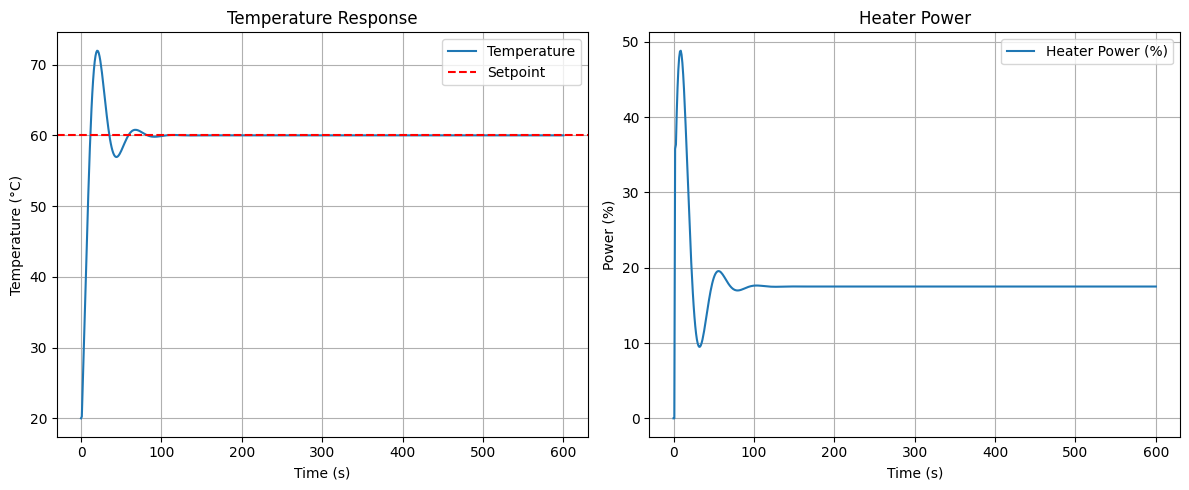

In [16]:
# Plot the results
plt.figure(figsize=(12, 5))

# Plot temperature
plt.subplot(1, 2, 1)
plt.plot(time, temperature, label='Temperature')
plt.axhline(y=setpoint, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Response')
plt.legend()
plt.grid(True)

# Plot heater power
plt.subplot(1, 2, 2)
plt.plot(time, power, label='Heater Power (%)')
plt.xlabel('Time (s)')
plt.ylabel('Power (%)')
plt.title('Heater Power')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

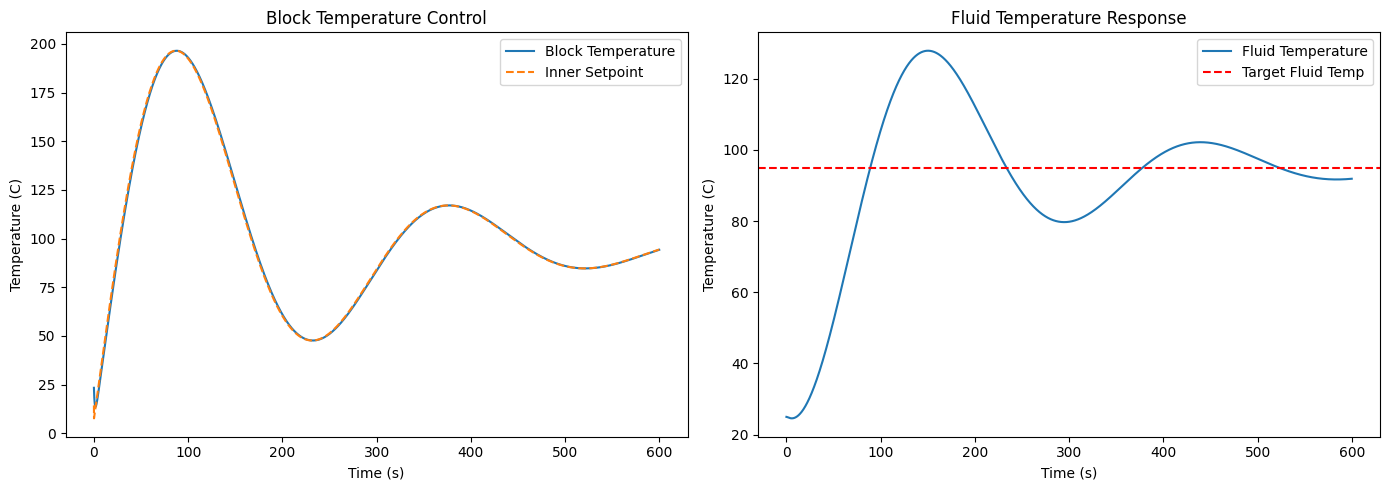

In [17]:
# Simplified nested PID control simulation in Python

# Define the PID controller class
class PIDController:
    def __init__(self, kp, ki, kd, setpoint=0):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.integral = 0
        self.last_error = 0

    def update(self, measured_value, dt):
        error = self.setpoint - measured_value
        self.integral += error * dt
        derivative = (error - self.last_error) / dt
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.last_error = error
        return output

# Define the simulation parameters
dt = 0.1  # time step (s)
total_time = 600  # total simulation time (s)
ambient_temp = 25  # ambient temperature (C)
battery_voltage = 3.3  # battery voltage (V)

# Initialize the PID controllers for both loops
outer_pid = PIDController(kp=0.1, ki=0.05, kd=0.01)
inner_pid = PIDController(kp=1.0, ki=0.1, kd=0.05)

# Set the initial conditions
block_temp = ambient_temp  # initial block temperature (C)
fluid_temp = ambient_temp  # initial fluid temperature (C)
outer_pid.setpoint = 95  # target fluid temperature (C)
inner_pid.setpoint = block_temp  # initial inner loop setpoint (C)

# Simulation storage
times = np.arange(0, total_time, dt)
block_temps = []
fluid_temps = []
inner_setpoints = []

# Simulation loop
for t in times:
    # Update the outer loop (fluid temperature control)
    outer_setpoint = outer_pid.update(fluid_temp, dt)
    
    # Update the inner loop (block temperature control) setpoint based on outer loop
    inner_pid.setpoint = outer_setpoint
    power = inner_pid.update(block_temp, dt)
    
    # Power scaling based on battery voltage
    scaled_power = power * (battery_voltage / 3.3)
    
    # Thermal model for block temperature change
    block_temp += (scaled_power - (block_temp - ambient_temp) * 0.1) * dt
    
    # Simple thermal transfer model from block to fluid
    fluid_temp += (block_temp - fluid_temp) * 0.01 * dt
    
    # Store simulation data
    block_temps.append(block_temp)
    fluid_temps.append(fluid_temp)
    inner_setpoints.append(inner_pid.setpoint)

# Plot the results
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(times, block_temps, label='Block Temperature')
plt.plot(times, inner_setpoints, label='Inner Setpoint', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.title('Block Temperature Control')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(times, fluid_temps, label='Fluid Temperature')
plt.axhline(y=outer_pid.setpoint, color='r', linestyle='--', label='Target Fluid Temp')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.title('Fluid Temperature Response')
plt.legend()

plt.tight_layout()
plt.show()
